In [1]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load accepted loan file
accepted_loans = pd.read_csv(r"C:\Users\amand\OneDrive\Project creator\Loan application risk scorecard\archive\accepted_2007_to_2018q4\accepted_2007_to_2018Q4.csv", engine="pyarrow")

In [5]:
# Filter and select columns
clean_loans = accepted_loans[
    (accepted_loans['annual_inc'].notnull()) &
    (accepted_loans['fico_range_low'].notnull()) &
    (accepted_loans['loan_amnt'] > 0)
][[
    'id', 'annual_inc', 'fico_range_low', 'fico_range_high', 'int_rate', 'dti',
    'loan_amnt', 'purpose', 'home_ownership', 'term', 'loan_status', 'emp_length',
    'zip_code', 'addr_state', 'application_type'
]].copy()

# Create risk bucket
def assign_risk_bucket(status):
    if status in ['Charged Off', 'Default']:
        return 'High Risk'
    elif status in ['Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period']:
        return 'Medium Risk'
    elif status == 'Fully Paid':
        return 'Low Risk'
    else:
        return 'Medium Risk'

clean_loans['risk_bucket'] = clean_loans['loan_status'].apply(assign_risk_bucket)

In [7]:
# Average FICO
clean_loans['fico_avg'] = (clean_loans['fico_range_low'] + clean_loans['fico_range_high']) / 2

# Clean term and employment length
clean_loans['term'] = clean_loans['term'].str.extract('(\d+)').astype(float)
clean_loans['emp_length'] = clean_loans['emp_length'].fillna('Unknown')

# Save to CSV
clean_loans.to_csv(r"C:\Users\amand\OneDrive\Project creator\Loan application risk scorecard\clean_loans.csv", index=False)

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\amand\AppData\Local\Temp\ipykernel_27220\1618881249.py:5: SyntaxWarning: invalid escape sequence '\d'
  clean_loans['term'] = clean_loans['term'].str.extract('(\d+)').astype(float)


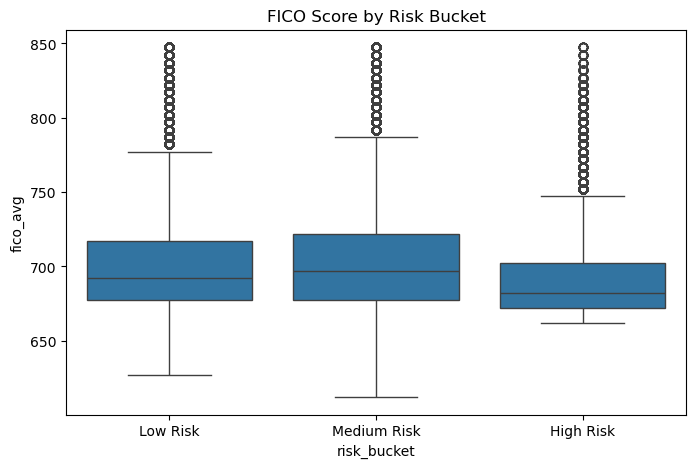

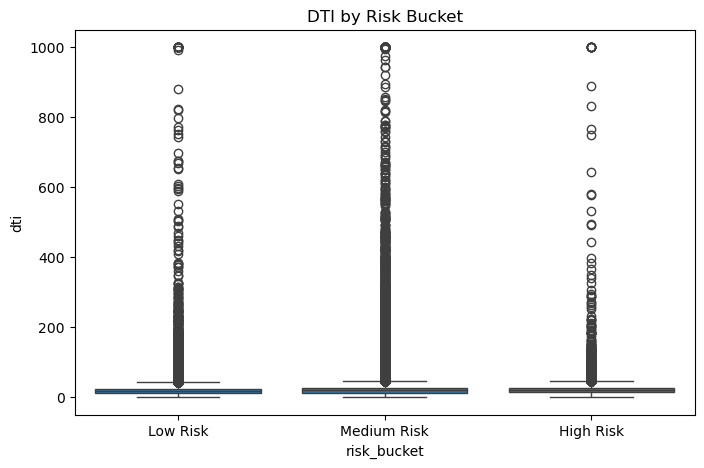

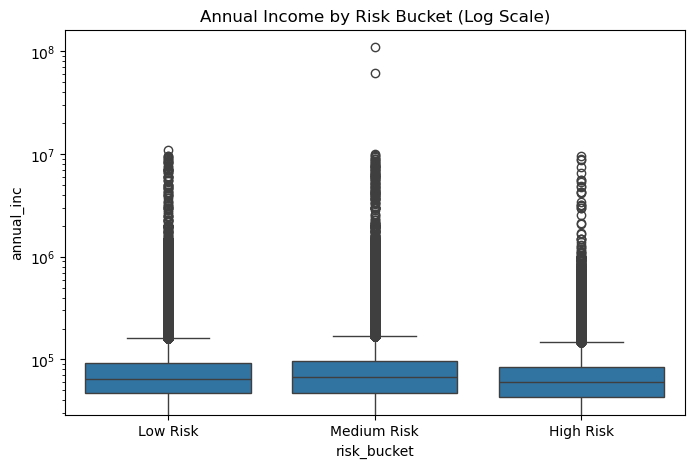

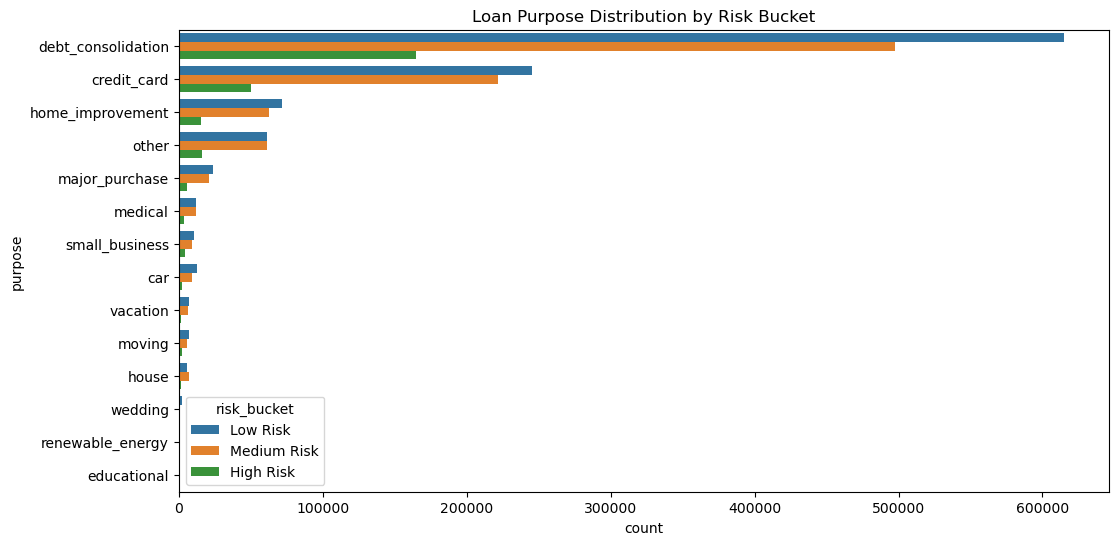

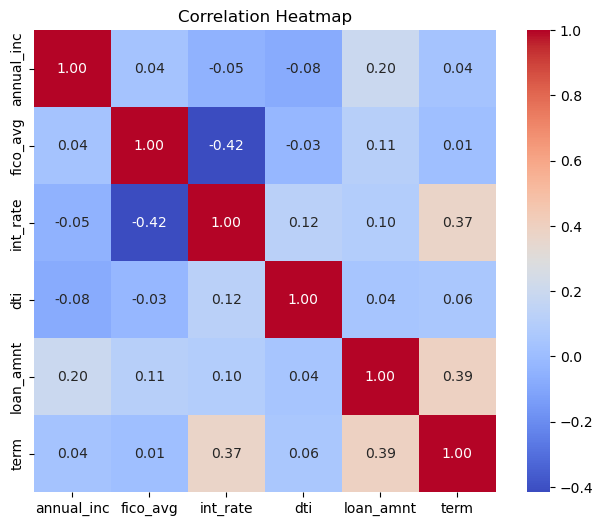

In [9]:

# Optional: Sample to speed up plotting
df_sample = clean_loans#df.sample(n=10000, random_state=42)

# Boxplot: FICO by Risk Bucket
plt.figure(figsize=(8, 5))
sns.boxplot(x="risk_bucket", y="fico_avg", data=df_sample, order=["Low Risk", "Medium Risk", "High Risk"])
plt.title("FICO Score by Risk Bucket")
plt.show()

# Boxplot: DTI by Risk Bucket
plt.figure(figsize=(8, 5))
sns.boxplot(x="risk_bucket", y="dti", data=df_sample, order=["Low Risk", "Medium Risk", "High Risk"])
plt.title("DTI by Risk Bucket")
plt.show()

# Boxplot: Income by Risk Bucket (log scale)
plt.figure(figsize=(8, 5))
sns.boxplot(x="risk_bucket", y="annual_inc", data=df_sample, order=["Low Risk", "Medium Risk", "High Risk"])
plt.yscale("log")
plt.title("Annual Income by Risk Bucket (Log Scale)")
plt.show()

# Countplot: Purpose by Risk
plt.figure(figsize=(12, 6))
sns.countplot(data=df_sample, y="purpose", hue="risk_bucket", order=df_sample["purpose"].value_counts().index)
plt.title("Loan Purpose Distribution by Risk Bucket")
plt.show()

# Correlation Heatmap
numeric_cols = ['annual_inc', 'fico_avg', 'int_rate', 'dti', 'loan_amnt', 'term']
plt.figure(figsize=(8, 6))
sns.heatmap(df_sample[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

df = df_sample

# Prepare features and target
df = df[['fico_avg', 'dti', 'annual_inc', 'loan_amnt', 'purpose', 'home_ownership', 'risk_bucket']].dropna()
target_map = {'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2}
X = df.drop(columns='risk_bucket')
y = df['risk_bucket'].map(target_map)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Feature Engineering
numeric_features = ['fico_avg', 'dti']
categorical_features = ['purpose', 'home_ownership']

preprocessor = ColumnTransformer(transformers=[
    ('fico_bin', KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile'), ['fico_avg']),
    ('dti_bin', KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile'), ['dti']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Modeling pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_map.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.49      0.81      0.61    322935
 Medium Risk       0.47      0.26      0.33    274193
   High Risk       0.27      0.00      0.00     80558

    accuracy                           0.49    677686
   macro avg       0.41      0.36      0.32    677686
weighted avg       0.46      0.49      0.43    677686

Confusion Matrix:
[[260844  62034     57]
 [203158  70986     49]
 [ 63154  17364     40]]


In [17]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 4.2/150.0 MB 28.1 MB/s eta 0:00:06
   -- ------------------------------------- 11.0/150.0 MB 29.9 MB/s eta 0:00:05
   ---- ----------------------------------- 18.4/150.0 MB 32.2 MB/s eta 0:00:05
   ----- ---------------------------------- 20.4/150.0 MB 26.4 MB/s eta 0:00:05
   ------ --------------------------------- 24.9/150.0 MB 25.5 MB/s eta 0:00:05
   -------- ------------------------------- 30.9/150.0 MB 25.8 MB/s eta 0:00:05
   --------- ------------------------------ 37.2/150.0 MB 26.6 MB/s eta 0:00:05
   ----------- ---------------------------- 43.3/150.0 MB 27.0 MB/s eta 0:00:04
   ------------- -------------------------- 49.8/150.0 MB 27.6 MB/s eta 0:00:04
   --------------- ------------------------ 56.4/150.0 MB 27.8 MB/s eta 0:00:04
   ---------------- ----------------------- 62.9/150.0 MB 28.0 MB/s eta 0:00:04
   ------------------ --------------------- 67.9/1

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier


# Load clean data
df = df_sample#pd.read_csv(r"C:\Users\amand\OneDrive\Project creator\Loan application risk scorecard\clean_loans.csv")


# Select features and target
df = df[['fico_avg', 'dti', 'annual_inc', 'loan_amnt', 'purpose', 'home_ownership', 'risk_bucket']].dropna()
target_map = {'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2}
X = df.drop(columns='risk_bucket')
y = df['risk_bucket'].map(target_map)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Feature preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('fico_bin', KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile'), ['fico_avg']),
    ('dti_bin', KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile'), ['dti']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['purpose', 'home_ownership'])
])

# XGBoost classifier
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight=3,  # You can tune this based on class ratios
    random_state=42
)

# Build pipeline
from sklearn.pipeline import make_pipeline
model = make_pipeline(preprocessor, xgb_model)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("📊 Classification Report (XGBoost):")
print(classification_report(y_test, y_pred, target_names=target_map.keys()))

print("🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

C:\Users\amand\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:40:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Classification Report (XGBoost):
              precision    recall  f1-score   support

    Low Risk       0.49      0.85      0.62    322935
 Medium Risk       0.50      0.22      0.30    274193
   High Risk       0.00      0.00      0.00     80558

    accuracy                           0.49    677686
   macro avg       0.33      0.36      0.31    677686
weighted avg       0.44      0.49      0.42    677686

🧮 Confusion Matrix:
[[274284  48648      3]
 [214624  59569      0]
 [ 68953  11605      0]]


In [11]:

import pandas as pd

# Load clean data
df = pd.read_csv(r"C:\Users\amand\OneDrive\Project creator\Loan application risk scorecard\clean_loans.csv")


# Drop missing values needed for FICO and DTI comparison
df = df[['fico_avg', 'dti', 'risk_bucket']].dropna()

# Apply rule-based logic
def assign_rule_risk(fico, dti):
    if fico > 700 and dti < 15:
        return 'Low Risk'
    elif 640 <= fico <= 700 or (15 <= dti <= 30):
        return 'Medium Risk'
    elif fico < 640 or dti > 30:
        return 'High Risk'
    else:
        return 'Medium Risk'

df['rule_based_risk'] = df.apply(lambda row: assign_rule_risk(row['fico_avg'], row['dti']), axis=1)


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Ensure both columns exist and are aligned
df = df[df['risk_bucket'].notna() & df['rule_based_risk'].notna()]

# Encode labels for comparison
label_map = {'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2}
y_true = df['risk_bucket'].map(label_map)
y_pred = df['rule_based_risk'].map(label_map)

# Evaluation
print("📊 Comparison: Rule-Based vs Model-Based (risk_bucket)")
print(classification_report(y_true, y_pred, target_names=label_map.keys()))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

📊 Comparison: Rule-Based vs Model-Based (risk_bucket)
              precision    recall  f1-score   support

    Low Risk       0.51      0.18      0.26   1076448
 Medium Risk       0.39      0.76      0.52    913977
   High Risk       0.10      0.04      0.06    268528

    accuracy                           0.40   2258953
   macro avg       0.33      0.33      0.28   2258953
weighted avg       0.41      0.40      0.34   2258953

Confusion Matrix:
[[188465 851536  36447]
 [157219 697409  59349]
 [ 24174 233836  10518]]
